In [1]:
import lazy_pipeline as lpipe

# Prepare the data

Load data

In [2]:
df = lpipe.load_data()
print(df.shape)
df.head()

(958, 10)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,o,x,True
2,x,x,x,x,o,o,o,b,b,True
3,x,x,x,x,o,o,b,o,b,True
4,x,x,x,x,o,o,b,b,o,True


Binarize data

In [3]:
y_name = 'V10'

In [4]:
y = df[y_name]
X = lpipe.binarize_data(df.drop(y_name, axis=1))
print(X.shape)
X.head()

(958, 27)


,V1: b,V1: o,V1: x,V2: b,V2: o,V2: x,V3: b,V3: o,V3: x,V4: b,...,V6: x,V7: b,V7: o,V7: x,V8: b,V8: o,V8: x,V9: b,V9: o,V9: x
0,False,False,True,False,False,True,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
3,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,False
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,True,False,False,False,True,False


Shuffle the data to drop any initial ordering of rows. For example, if the dataset is constructed first from all positive examples and then all negative examples.

_NB: Skip this step if your data is sequential and rows ordering is important. For example, if your dataset contains a "date" feature._

In [5]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

Assume that at the very begining, we know the labels only for the first 20% of rows.

In [6]:
n_train = int(len(X)*0.2)
n_test = len(X) - n_train
n_train, n_test

(191, 767)

# Make predictions

Make predictions

In [7]:
%%time
y_preds = list(lpipe.predict_array(X, y, n_train, use_tqdm=True))

Predicting step by step: 100%|██████████| 958/958 [01:33<00:00, 10.30it/s]

CPU times: user 1min 33s, sys: 2.11 s, total: 1min 35s
Wall time: 1min 33s


In [8]:
%%time
y_preds_fixedtrain = list(lpipe.predict_array(X, y, n_train, use_tqdm=True, update_train=False))

Predicting step by step: 100%|██████████| 958/958 [00:26<00:00, 36.01it/s]

CPU times: user 26.9 s, sys: 650 ms, total: 27.5 s
Wall time: 26.6 s


Evaluate predictions

In [9]:
y_test = y[n_train:]

In [10]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    for fixed_train in [False, True]:
        score_name = score_f.__name__
        score_name += '_fixedtrain' if fixed_train else ''
        preds = y_preds_fixedtrain if fixed_train else y_preds
        
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

/home/egor/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/egor/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


# Analyze results

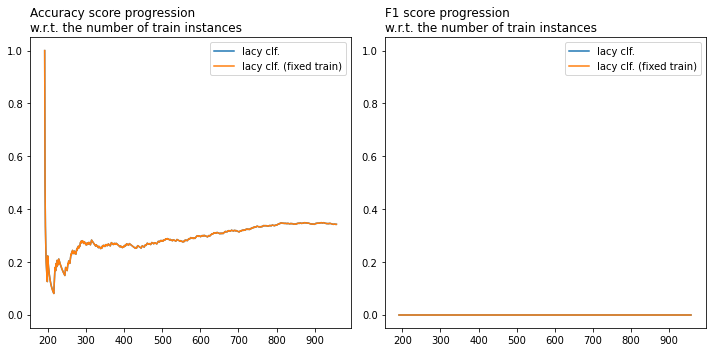

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


for ax, t in zip(axs,['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='lacy clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='lacy clf. (fixed train)')
    
    ax.legend()
    
    ax.set_title('\n'.join([f"{t.replace('_', ' ').capitalize()} progression", "w.r.t. the number of train instances"]), loc='left')
    
fig.tight_layout()
plt.show()

In conclusion:

...